# Knowledge distillation experiment in a Computer Vision problem

Inspired by Coursera programming task on recognizing hand signs (from 0 to 5), I decided to carry out the research on this task. The idea of my knowledge distillation experiment is the following:
 

*   to learn a cumbersome model on training data
*   the cumbersome model almost always produces the correct answer
with very high confidence, but still much of the information about the learned function resides in the ratios of very small probabilities in the soft targets -> while learning it is essential to pay attention on the `Temperature` hyperparameter - it is applied to the softmax output of the model to increase the level of chaos in a system (to increase entropy) - to increase values and impact of small probabilities
*   try to learn a simple NN model, that imitates the results of the cumbersome model on the same training set
*   try to learn this simple model just as the cumbersome model(on the same X_train, Y_train)
*   compare two approaches and see if knowledge distillation works


Let's start with importing all nesessary tools and frameworks!

I will use Keras to learn the cumbersome model - it is my realization of the famous NN model - ResNet50. Tensorflow.v1 will be used to learn a simple NN model (I have an experience of working with tf.v1 but not tf.v2, still it is not essential here).

resnet_utils.py contains load_dataset() function (took this code and the dataset(h5 files) from Coursera), random_mini_batches_nn() (my realization,which I used to write earlier).




In [106]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnet_utils import *
from keras.initializers import glorot_uniform # Xavier initialization of weights
import scipy.misc
import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
%matplotlib inline 

import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
tf.disable_eager_execution()
tf.disable_v2_behavior()
from resnet_utils import *

import keras.backend as K
K.set_image_data_format('channels_last') #the last dimension in examples is a number of channels
K.set_learning_phase(1) # training phase

Temperature = 1000

I found it convenient to update the `Temperature` at the beginning. Small values (up to ~500) didn't work for my task, big values(from ~1200) didn't work as well. To my mind, it is connected with insufficient and excessive level of chaos in a system. The optimal `Temperature` to get more useful info from the output of the cumbersome model is ~1000.


Let's move on to the realization of ResNet50!
There are identity_block() and convolutional_block() functions below, which will be used in the model.

In [107]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: combine shortcut and main values - it is a main part of such residual block
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

In [108]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: combine shortcut and main values - it is a main part of such residual block
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

Combine keras layers and residual blocks to an entire model!

In [109]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.activations.softmax(X / Temperature, axis=-1)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Compile the model.

In [113]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Upload datasets (not my code).

In [116]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Number of epochs needed to achieve ~ 98% of accuracy on the test set is about 70.

In [139]:
model.fit(X_train, Y_train, epochs = 70, batch_size = 64)

Train on 1080 samples
Epoch 1/4
1080/1080 [==============================] - 1s 1ms/sample - loss: 0.0222 - acc: 0.9954
Epoch 2/4
 128/1080 [==>...........................] - ETA: 0s - loss: 0.0091 - acc: 1.0000

KeyboardInterrupt: ignored

In [140]:
preds = model.evaluate(X_test, Y_test)
print("Loss = " + str(preds[0]))
print("Accuracy = " + str(preds[1]))
Y_predicted_train = model.predict(X_train)
Y_train_nn = Y_predicted_train.T

Loss = 0.08346204782525699
Accuracy = 0.975


In [53]:
print(Y_train_nn.shape)

(6, 1080)


In [54]:
print(Y_train_nn)

[[2.7947179e-03 9.9498832e-01 5.1954254e-03 ... 2.5325054e-03
  1.7384855e-03 3.0180456e-03]
 [1.1713703e-03 1.0195682e-03 2.9316185e-02 ... 1.8302143e-02
  6.8036065e-04 1.0982596e-03]
 [1.1679714e-03 8.5650530e-04 9.4593859e-01 ... 9.7246087e-01
  9.7452989e-04 9.7090378e-04]
 [1.6292720e-03 9.0219011e-04 9.7298687e-03 ... 2.8609415e-03
  8.1157702e-04 1.0521575e-03]
 [9.2805410e-03 1.1080429e-03 5.6534149e-03 ... 2.2017148e-03
  9.8766673e-01 7.6923184e-03]
 [9.8395616e-01 1.1254089e-03 4.1665197e-03 ... 1.6418244e-03
  8.1283050e-03 9.8616832e-01]]


Here is the simple NN model comes in! Firstly, let's bring the train/test data to the appropriate view (not my code). 

In [141]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


Define all needed functions to run a model. W1 - parameters of size[n_of_classes, image_size], where image_size = 64 * 64 * 3 = 12288, n_of_classes = 6.

In [142]:
def create_placeholders(n_x, n_y):
    
    X = tf.placeholder(tf.float32, [n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, [n_y, None], name = 'Y')
    
    return X, Y

def initialize_parameters():
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [6,12288], initializer = tf.initializers.glorot_uniform(seed = 1))
    b1 = tf.get_variable("b1", [6,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1
                 }
    
    return parameters

def forward_propagation(X, parameters):

    W1 = parameters['W1']
    b1 = parameters['b1']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                                                          
    
    return Z1
 

def compute_cost(Z1, Y):
    
    logits = tf.transpose(Z1)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost



Combine everything to a model_nn. I used this model to count parameters_soft(this NN imitates the cumbersome one) and parameters_hard(tries to learn independently from any models).  

In [145]:
def model_nn(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 800, minibatch_size = 64, print_cost = True):


    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    seed = 3
    print(X_train.shape)
    n_x, m = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                          # n_y : output size
    costs = []                                      # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters() 
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_nn(X_train, Y_train, minibatch_size, seed)
            # learning_rate = learning_rate * 10 / (10 + epoch)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # The line that runs the graph on a minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

(12288, 1080)
Cost after epoch 0: 0.484767
Cost after epoch 100: 0.219910
Cost after epoch 200: 0.162240
Cost after epoch 300: 0.132405
Cost after epoch 400: 0.110868
Cost after epoch 500: 0.098246
Cost after epoch 600: 0.086238
Cost after epoch 700: 0.076537
Cost after epoch 800: 0.069460
Cost after epoch 900: 0.063148
Cost after epoch 1000: 0.059083
Cost after epoch 1100: 0.055874
Cost after epoch 1200: 0.052359
Cost after epoch 1300: 0.049892
Cost after epoch 1400: 0.046928


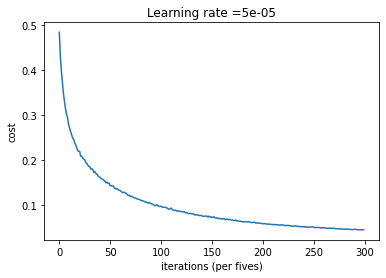

Parameters have been trained!
Train Accuracy: 0.99814814
Test Accuracy: 0.85833335


In [144]:
parameters_soft = model_nn(X_train, Y_train_nn, X_test, Y_test)

I've got maximum 92.5% of test accuracy, but the result changes over my trials and sometimes is not so good. However, I achieved ~ 92% several times, so let's consider this accuracy as final for imitating our cumbersome model.

(12288, 1080)
Cost after epoch 0: 0.486033
Cost after epoch 100: 0.165543
Cost after epoch 200: 0.105999
Cost after epoch 300: 0.075136
Cost after epoch 400: 0.055131
Cost after epoch 500: 0.043367
Cost after epoch 600: 0.033893
Cost after epoch 700: 0.024959


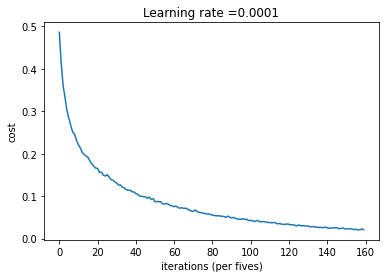

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.8833333


In [146]:
parameters_hard = model_nn(X_train, Y_train, X_test, Y_test)

Here I've got maximum 88% of test accuracy (and 87,5%, when the model was overfitted). For my simple model it seems like the highest accuracy, which can be achieved at current datasets(the model learned its maximum).